# Message Classifier, multi class, multi label
Gilbert François Duivesteijn (gilbert@deep-impact.ch)

<img src="images/dt_c111012.gif" width=800>

In [1]:
import os
import pickle as pkl
import re
import string

import nltk
from nltk import tokenize
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from lib.utils import plot_confusion_matrix
from lib.utils import plot_y_proba
from lib.utils import show_pred_proba
np.set_printoptions(precision=3, linewidth=100)

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
dict_classes = {
    1: 'late/early',
    2: 'holidays',
    3: 'home office',
    4: 'med app',
    5: 'ill',
    6: 'business',
    7: 'in office',
    8: 'miscellaneous'
}

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gilbert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gilbert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Library functions

Some helper functions.

In [5]:
stemmer = nltk.PorterStemmer()
analyzer = CountVectorizer().build_analyzer()


def stemmed(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


def mask_integers(text):
    return re.sub(r'\d+', '_NUMBER', text)


def mask_times(text):
    """
    Replaces times written like 12:50, 1PM, 4:15am, etc to _time token.
    :param    text    Input text
    :return           Output text with replaced times.
    """
    re_time1 = '\d{1,2}[:.]\d{2}(?:am|pm|AM|PM)'
    re_time2 = '\d{1,2}[:.]\d{2}'
    re_time3 = '\d{1,2}(?:am|pm|AM|PM)'
    rec_time = re.compile(re_time1 + '|' + re_time2 + '|' + re_time3)
    return re.sub(rec_time, '_TIME', text)


def mask_emojis(text):
    """
    Replaces all different emojis to _emoji token.
    :param    text    Input text
    :return           Output text with replaced emojis.    
    """
    re_icons = ':[a-z-_]*:'
    re_ldsd = '\<(.*?)\>'
    rec_icons = re.compile(re_icons + "|" + re_ldsd)
    return re.sub(rec_icons, '_EMOJI', text)


def mask_all(text):
    text = mask_times(text)
    text = mask_emojis(text)
    text = mask_integers(text)
    return text


def train_and_test(steps, X_train, X_test, y_train, y_test):
    """
    Trains and tests the pipeline with the given steps. 
    :param steps:       List of operations inside the pipeline.
    :param X_train:     Training data
    :param X_test:      Training labels
    :param y_train:     Testing data
    :param y_test:      Testing labels
    :return:            Trained model
    """
    pipeline = Pipeline(steps)
    folds = 10
    xval_score = cross_val_score(pipeline, X_train, y_train, cv=folds, n_jobs=-1)
    
    xv_min = np.min(xval_score)
    xv_max = np.max(xval_score)
    xv_mean = np.mean(xval_score)
    xv_std = np.std(xval_score)
    print('{} fold Cross Validation Score: <{:.2f}, {:.2f}>; µ={:.2f}'.format(folds, xv_min, xv_max, xv_mean))
    pipeline = pipeline.fit(X_train, y_train)
    print('Score on test set: {:.2f}'.format(pipeline.score(X_test, y_test)))
    return pipeline


def tag_message(pipeline, message):
    y_pred = pipeline.predict([message])[0]
    print('{:>20} | {}'.format(dict_classes[y_pred], message))
    

def multitag_message(pipeline, message):
    y_pred = pipeline.predict([message])[0]
    tags = [dict_classes[i+1] for i, yi in enumerate(y_pred) if yi == 1]
    # Remove `misc` tag if the list contains other tags as well.
    if len(tags) > 1 and dict_classes[8] in tags:
        del tags[tags.index(dict_classes[8])]
    print('{:>30} | {}'.format('['+'] ['.join(tags)+']', message))

## Load the annotated data

Load the data and split the data in a training and test set. 

_Note that we load the same annotated dataset as we did for training the single class predictions._ 

In [7]:
df_messages = pd.read_pickle('data/messages-cls.pkl')

# Remove all rows which have no annotation
df_messages = df_messages.dropna()

# Convert the classification column to unsigned int, in case it is stored as string
df_messages['class'] = df_messages.loc[:, 'class'].astype(np.uint8).values

X = df_messages['text']
y = df_messages['class']

print('[.] Number of training samples: {}'.format(len(X)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

df_messages.head(5)

[.] Number of training samples: 1719


,ts,user,text,class,key
0,1.503303e+09,Balaemar,I have to pick up my car from the garage tomor...,1,1503303350U035FRUCY
1,1.503302e+09,Ragaenys,"I won’t be here tomorrow, one day vacation",2,1503301710U4A2FRAQ4
2,1.503296e+09,Myke,Missed connection in Zurich. Will be about 5-1...,1,1503296123U0MGNKETU
3,1.503260e+09,Drevyn,Enjoy!,8,1503259722U035B8PRU
4,1.503258e+09,Gaelralis,I am away for 2 weeks in iceland :flag-is:,2,1503258060U0HLAK1T6


## Multi label predictions with probabilities

Let's review our first classifier and see if we can modify it to do multi class predictions. Change the `LinearSVC` to `SVC` with linear kernel and set the parameter `probability` to `True`.

In [8]:
steps = [('vectorizer', CountVectorizer()),
         ('classifier', SVC(kernel='linear', probability=True, random_state=1))]
pipeline1 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.75, 0.86>; µ=0.80
Score on test set: 0.80


threshold: 0.200
I do home office. 

y_pred: [0.103 0.01  0.689 0.021 0.034 0.008 0.015 0.12 ]


<IPython.core.display.Javascript object>


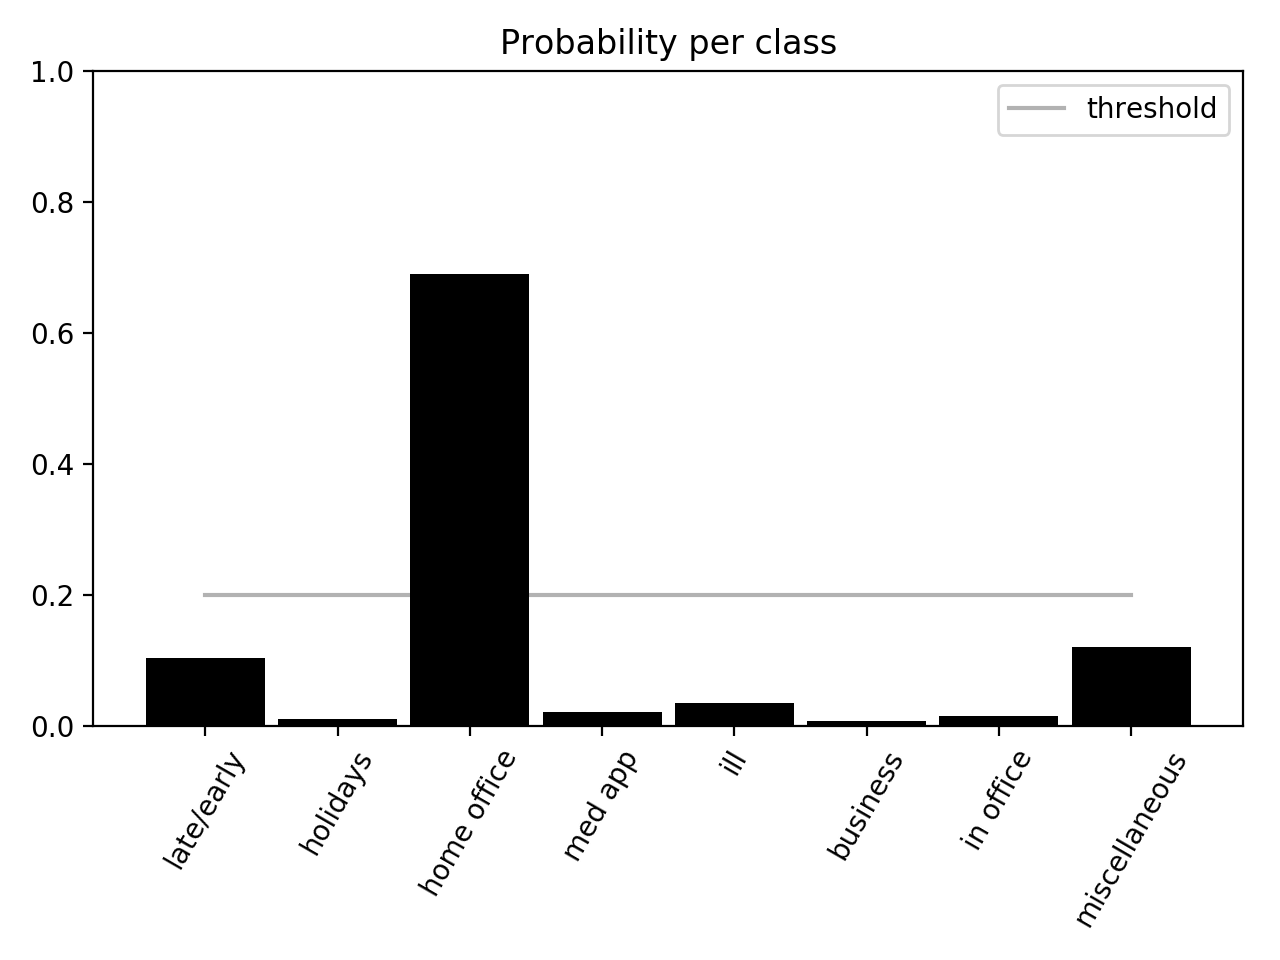

* home office


In [9]:
doc_list = ['I do home office.']
y_pred_list = pipeline1.predict_proba(doc_list)
show_pred_proba(y_pred_list, doc_list, dict_classes, threshold=0.2)

Now the challenge is how to set the value of the threshold. Possibilities are:
- Fixed threshold, e.g. Label is true if $y_{pred}^i > 0.2$
- Dynamic threshold, e.g. Label is true if $y_{pred}^i > \frac{1}{4}\max(y_{pred})$

threshold: 0.112
I go a bit earlier, have an appointment at the doctor.  Then I will do home office 

y_pred: [0.448 0.002 0.132 0.37  0.032 0.002 0.003 0.01 ]


<IPython.core.display.Javascript object>


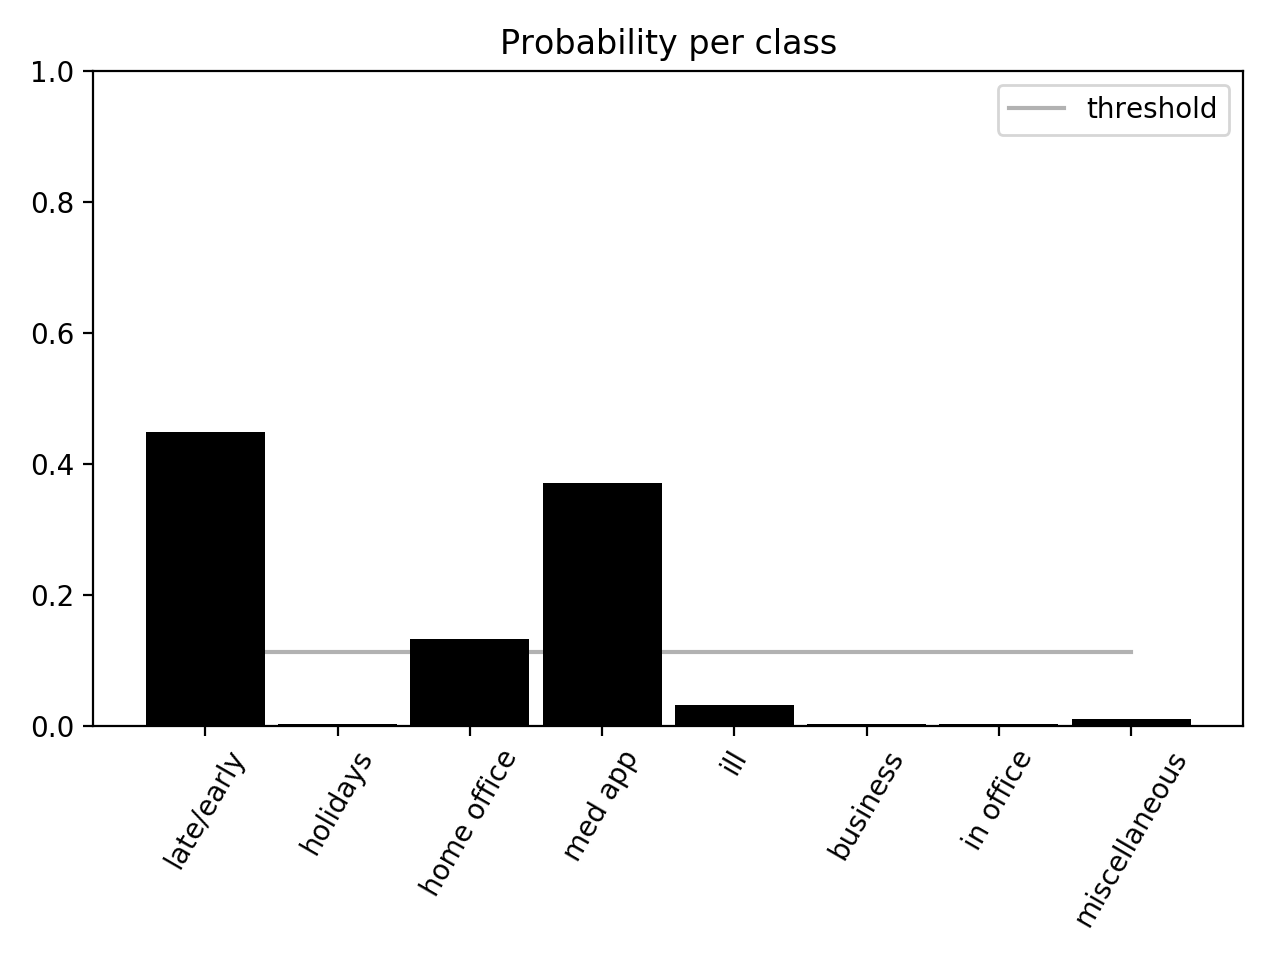

* late/early
* home office
* med app


In [10]:
doc_list = [
    'I go a bit earlier, have an appointment at the doctor.  Then I will do home office',
]
y_pred_list = pipeline1.predict_proba(doc_list)

show_pred_proba(y_pred_list, doc_list, dict_classes)

## Multi label predictions with 1-vs-rest classifier

In [11]:
df_messages = pd.read_pickle('data/messages-cls-mc.pkl')

# Remove all rows which have no annotation
df_messages = df_messages.dropna()

# Convert the classification column to unsigned int, in case it is stored as string
df_messages['class'] = df_messages.loc[:, 'class'].astype(np.uint8).values

X = df_messages['text']
y = df_messages['multiclass']
df_messages.head(10)

,ts,user,text,class,key,multiclass
0,1.503303e+09,Balaemar,I have to pick up my car from the garage tomor...,1,1503303350U035FRUCY,"[1, 8]"
1,1.503302e+09,Ragaenys,"I won’t be here tomorrow, one day vacation",2,1503301710U4A2FRAQ4,[2]
2,1.503296e+09,Myke,Missed connection in Zurich. Will be about 5-1...,1,1503296123U0MGNKETU,[1]
3,1.503260e+09,Drevyn,Enjoy!,8,1503259722U035B8PRU,[8]
4,1.503258e+09,Gaelralis,I am away for 2 weeks in iceland :flag-is:,2,1503258060U0HLAK1T6,[2]
5,1.503223e+09,Gonaleos,Monday is the first day in school for my son a...,1,1503222795U3W886EF4,"[1, 8]"
6,1.503063e+09,Vaerys,Going to leave around 4:50 because I need to g...,1,1503063218U0PLNK7EK,"[1, 3]"
7,1.503059e+09,Taengaeron,"I am away between 3-4 for private stuff, be ba...",1,1503059074U4C55CKGX,"[1, 3]"
8,1.503058e+09,Baegar,I will move to HO. I will be in 2 different Te...,3,1503057526U035J4RG4,"[3, 6, 8]"
9,1.503057e+09,Eliar,Need to leave around 16:45. Will be available ...,1,1503056595U0A8NPHRD,"[1, 3]"


Convert the categorical class vectors to binary vectors with `MultiLabelBinarizer`.

In [12]:
ym = MultiLabelBinarizer().fit_transform(y)
print(ym.shape)
ym

(1719, 8)


array([[1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, ym, test_size=0.20, random_state=1)

In [14]:
# Choose one of the step options and see the difference in accuracy.

# steps = [('vectorizer', CountVectorizer()),
#          ('classifier', OneVsRestClassifier(SVC(kernel='linear')))]

steps = [('vectorizer', CountVectorizer(ngram_range=(1,2), 
                                        preprocessor=mask_all, 
                                        analyzer=stemmed, 
                                        stop_words='english')),
         ('transformer', TfidfTransformer()),
         ('classifier', OneVsRestClassifier(SVC(kernel='linear')))]
pipeline2 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.51, 0.69>; µ=0.59
Score on test set: 0.62


The score seems not so great. Let's look at some misclassified documents to see what is going on...

In [ ]:
y_pred_list = pipeline2.predict(X_test).tolist()
y_test_list = y_test.tolist()
for index in range(len(y_pred_list))[:10]:
    if y_pred_list[index] != y_test_list[index]:
        print('[pred]: ', y_pred_list[index])
        print('[true]: ', y_test_list[index])
        print('[doc ]: ', X_test.iloc[index])
        print()

When inspecting the `predictions` and compare them to the `true` values, the model is doing better than the cross validation score and test score indicate. One reason for the low scores is that _all_ elements of the $y_{pred}^i$ vector have to be the same as $y_{true}^i$. This is much harder than matching a _one-hot_ vector, like in the case of multi class single label classification. Another reason is that some of the annotations from the dataset are open for debate.

How does the model do with some test documents?

In [ ]:
multitag_message(pipeline2, 'I don\'t feel well, stay home and don\'t come to the office.')
multitag_message(pipeline2, 'My alarm clock was not set properly. I come to the office asap.')
multitag_message(pipeline2, 'It is my scheduled day off, see you on Tuesday.')
multitag_message(pipeline2, 'I\'m having a terrible headache, I stay home and work from here.')
multitag_message(pipeline2, 'I work at home on Tuesday.')
multitag_message(pipeline2, 'In the morning I\'ve a meeting with IBM, I\'ll be back at 1pm.')
multitag_message(pipeline2, 'I\'m off, see you tomorrow.')
multitag_message(pipeline2, 'get well soon!')
multitag_message(pipeline2, 'I\'m away for a long lunch between 12:00 and 15:30')
multitag_message(pipeline2, 'I\'ve an appointment at 12:00 at the physiotherapy.')
multitag_message(pipeline2, 'I go to the doctor and will be online again after 18:00.')

Wow, not too bad.

## Multi label predictions with sentence tokenization

### Step 1: Build a sentence tokenizer

Let's make the following assumption:
- A document has only multiple class labels when it has multiple sentences.
- Every sentence contains only one class label.

For this model, every document will tokenized in sentences, then every sentence will be classified with a multi class, single label classifier.

NLTK has a sentence tokenizer, but combined sentences are not splitted. We have to do this ourselves. We will use part of speech (POS) tagging to analyse the sentence and see if it can be splitted or not.

In [24]:
def sentence_tokenizer(text, verbose=False):
    # Some input checking.
    if not isinstance(text, str):
        print('[!] Input type should be a string, not a {}'.format(type(text)))
        exit(1)
        
    # Split sentences with NLTK
    text_list_1 = nltk.sent_tokenize(text)
    
    # Split sentences with our POS tagging method
    text_list_2 = []
    for text in text_list_1:
        text_list_2 += custom_sentence_tokenizer(text, verbose)
    
    return text_list_2


def custom_sentence_tokenizer(text, verbose=False):
    # container for final result
    new_split = []
    
    # Split sentences by a comma, 'and' and 'or'.
    text_list = re.split(',| and | or | but | \(', text)
    
    # Remove white spaces and empty string elements from the list
    text_list = [x.strip() for x in text_list]
    text_list = list(filter(None, text_list))
        
    # Append first list element to the new list.
    new_split.append(text_list[0])
    
    # Check if the splits are valid sentences. If not, glue the parts together again.
    for index in range(1, len(text_list)):
        
        # Keep the split if both parts of the sentences contain a verb.
        if has_verb(text_list[index-1], verbose) and has_verb(text_list[index], verbose):
            new_split.append(text_list[index])
        # Glue the parts together again, since POS requirements are not met.
        else:
            new_split[-1] += ' ' + text_list[index]
    
    if verbose:
        print('[.] Input sentence:')
        print('    ', text)
        print('[.] Output sentence(s):')
        print('    ', new_split)
    return new_split
    

def has_verb(sentence, verbose=False):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    if verbose:
        print(pos_tagged)
    if 'VB' in [tag[1][:2] for tag in pos_tagged]:
        return True
    return False


def split_sentences_in_dataframe(df, verbose=False):
    new_df = pd.DataFrame()
    for index, row in df.iterrows():
        text = row['text']
        text_list = sentence_tokenizer(text, verbose)
        for text_part in text_list:
            new_row = row.copy()
            new_row['text'] = text_part
            new_df = new_df.append(new_row)
    return new_df

In [25]:
doc = "I'm afraid I can't explain myself, sir. Because I am not myself, you see?"
doc = "I have to leave around 11am, having a meeting with alice and will be back after 15:00."

Sentence tokenization with NLTK. Combined sentences are not tokenized.

In [ ]:
nltk.sent_tokenize(doc)

Sentence tokenization with our own implementation. Combined sentences are now tokenized as well.

In [26]:
sentence_tokenizer(doc, True)

[('I', 'PRP'), ('have', 'VBP'), ('to', 'TO'), ('leave', 'VB'), ('around', 'RP'), ('11am', 'CD')]
[('having', 'VBG'), ('a', 'DT'), ('meeting', 'NN'), ('with', 'IN'), ('alice', 'NN')]
[('having', 'VBG'), ('a', 'DT'), ('meeting', 'NN'), ('with', 'IN'), ('alice', 'NN')]
[('will', 'MD'), ('be', 'VB'), ('back', 'RB'), ('after', 'IN'), ('15:00', 'CD'), ('.', '.')]
[.] Input sentence:
     I have to leave around 11am, having a meeting with alice and will be back after 15:00.
[.] Output sentence(s):
     ['I have to leave around 11am', 'having a meeting with alice', 'will be back after 15:00.']


['I have to leave around 11am',
 'having a meeting with alice',
 'will be back after 15:00.']

### Step 2: Tokenize sentences of the original data and annotate

Use the above mentioned method to tokenize the documents and start annotating (by hand) the new tokenized documents. When this is done, we can continue with step 3.

### Step 3: Load new annotated data and train

In [16]:
df_messages = pd.read_pickle('data/messages-cls-ms.pkl')
df_messages.head(10)

,user,class,text,ts,key
0,Balaemar,8,I have to pick up my car from the garage tomor...,1.503303e+09,1503303350U035FRUCY
0,Balaemar,1,I have to leave at 15:45 on Thursday.,1.503303e+09,1503303350U035FRUCY
1,Ragaenys,2,I won’t be here tomorrow one day vacation,1.503302e+09,1503301710U4A2FRAQ4
2,Myke,1,Missed connection in Zurich.,1.503296e+09,1503296123U0MGNKETU
2,Myke,1,Will be about 5-10 mins late in the office,1.503296e+09,1503296123U0MGNKETU
2,Myke,1,so will miss the weekly today.,1.503296e+09,1503296123U0MGNKETU
3,Drevyn,8,Enjoy!,1.503260e+09,1503259722U035B8PRU
4,Gaelralis,2,I am away for 2 weeks in iceland :flag-is:,1.503258e+09,1503258060U0HLAK1T6
5,Gonaleos,8,Monday is the first day in school for my son,1.503223e+09,1503222795U3W886EF4
5,Gonaleos,8,I am going to go there with him,1.503223e+09,1503222795U3W886EF4


In [17]:
# Convert the class column to int, it might be stored as a string
df_messages['class'] = df_messages.loc[:, 'class'].astype(np.uint8).values
print('Number of documents: {}'.format(len(df_messages)))

Number of documents: 3105


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_messages['text'], 
                                                    df_messages['class'], 
                                                    test_size=0.20, 
                                                    random_state=1)

*WARNING* Running the gridsearch takes a long time.

In [ ]:
%%time
steps = [('vectorizer', CountVectorizer()),
         ('transformer', TfidfTransformer()),
         ('classifier', LinearSVC())]
pipeline3 = Pipeline(steps)

params = {
    'vectorizer__tokenizer': [None, nltk.tokenize.word_tokenize],
    'vectorizer__analyzer' : ['word', stemmed],
    'vectorizer__stop_words': [None, nltk.corpus.stopwords.words('english'), 'english'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
    'vectorizer__preprocessor': [None, mask_all, mask_integers, mask_times, mask_emojis],
    'classifier__C': np.logspace(-2, 2, 5),
    'classifier__gamma': np.logspace(-5, 3, 9)
}

gs = GridSearchCV(pipeline3, params, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_params_)
y_pred = gs.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))
print('Score on the test set: {:.2f}'.format(gs.score(X_test, y_test)))

In [19]:
steps = [('vectorizer', CountVectorizer(analyzer=stemmed,
                                        ngram_range=(1,2),
                                        stop_words='english',
                                        preprocessor=mask_all)),
         ('transformer', TfidfTransformer()),
         ('classifier', LinearSVC(C=1))]
pipeline4 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.82, 0.90>; µ=0.87
Score on test set: 0.88


In [20]:
y_pred = pipeline4.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          1       0.83      0.88      0.86       166
          2       0.97      0.91      0.94        32
          3       0.97      0.91      0.94       114
          4       0.93      0.74      0.83        35
          5       0.87      0.81      0.84        32
          6       0.88      0.92      0.90        25
          7       0.89      0.87      0.88        46
          8       0.85      0.89      0.87       171

avg / total       0.88      0.88      0.88       621



<IPython.core.display.Javascript object>


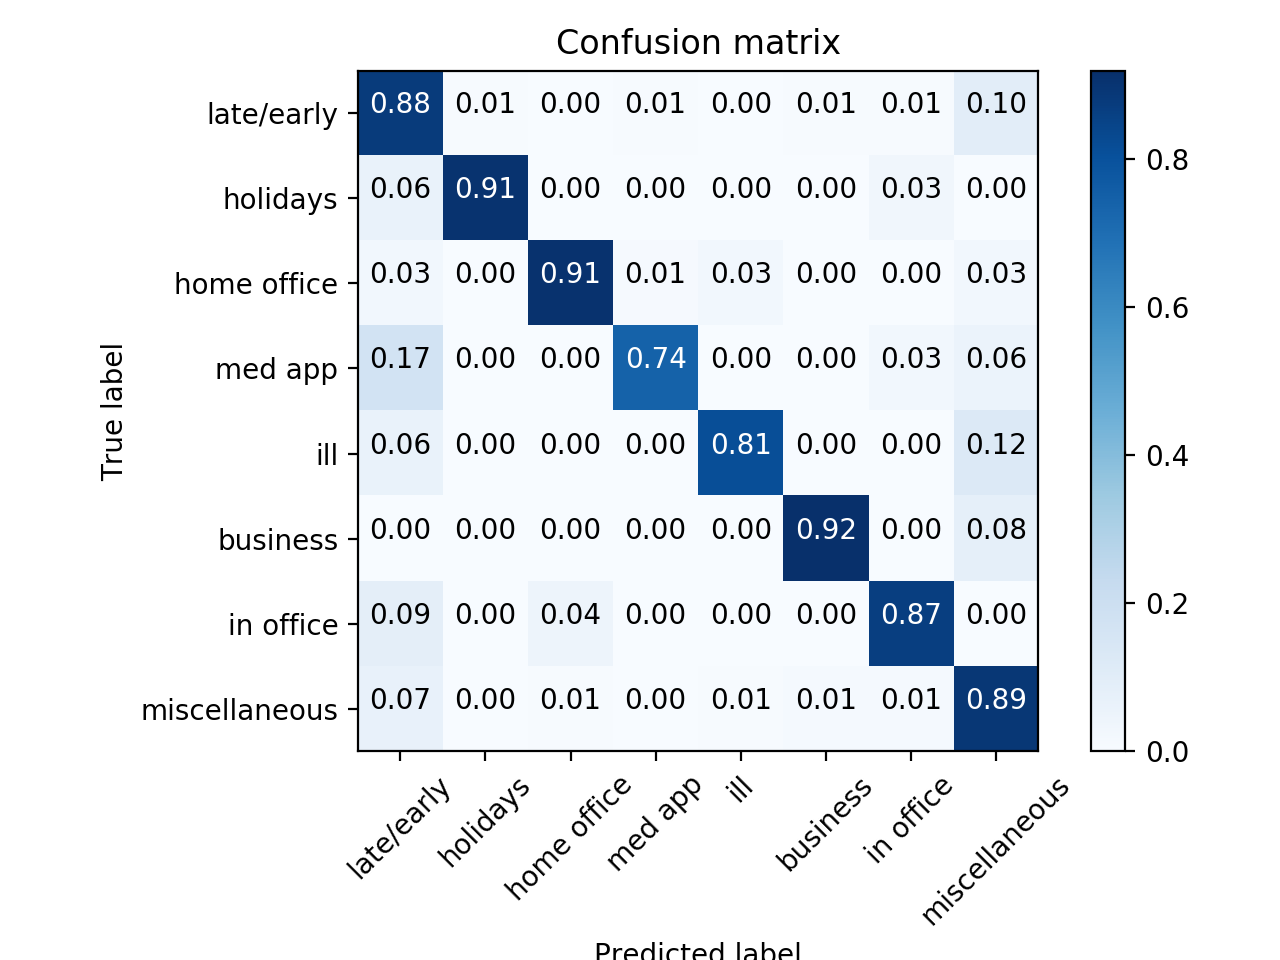

Normalized confusion matrix


In [21]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure()
plot_confusion_matrix(cm, classes=dict_classes.values(), normalize=True);

In [22]:
def multilabel3_message(model, doc):
    doc_list = sentence_tokenizer(doc)
    y_pred = pipeline4.predict(doc_list)
    # Remove double class predictions
    y_pred = list(set(y_pred))
    tags = [dict_classes[i] for i in y_pred]
    # Remove `misc` tag if the list contains other tags as well.
    if len(tags) > 1 and dict_classes[8] in tags:
        del tags[tags.index(dict_classes[8])]
    print('{:>30} | {}'.format('['+'] ['.join(tags)+']', doc))

In [27]:
multilabel3_message(pipeline4, 'My alarm clock was not set properly. I come to the office asap.')
multilabel3_message(pipeline4, 'It is my scheduled day off, see you on Tuesday.')
multilabel3_message(pipeline4, 'Not feeling well today, I stay home and work from here.')
multilabel3_message(pipeline4, 'I work at home on Tuesday.')
multilabel3_message(pipeline4, 'This morning I have a meeting at ACME.')
multilabel3_message(pipeline4, 'I\'m off, see you tomorrow.')
multilabel3_message(pipeline4, 'Get well soon!')
multilabel3_message(pipeline4, 'I\'m away for a long lunch between 12:00 and 15:30')
multilabel3_message(pipeline4, 'I\'ve an appointment at 12:00 at the physiotherapy.')

                  [late/early] | My alarm clock was not set properly. I come to the office asap.
        [holidays] [in office] | It is my scheduled day off, see you on Tuesday.
           [home office] [ill] | Not feeling well today, I stay home and work from here.
                 [home office] | I work at home on Tuesday.
                    [business] | This morning I have a meeting at ACME.
        [holidays] [in office] | I'm off, see you tomorrow.
               [miscellaneous] | Get well soon!
                  [late/early] | I'm away for a long lunch between 12:00 and 15:30
                     [med app] | I've an appointment at 12:00 at the physiotherapy.


## Notes

 [1, 2, 3, 4, 5, 6, 7, 8]

[1, 2, 3, 4]  [5, 6, 7, 8]

[1, 2] [3, 4] [5, 6] [7, 8]

[1][2] [3][4] [5][6] [7][8]

probability=True, random_state=1

## Multi label predictions with sentence tokenization and ensembles


Another idea is to train an ensemble of machines with different hyper parameters. It smoothes out the incluence of a specific hyperparameter and might give a better generalized probability.

In the example below, we train 6 machines with different settings and elements in the pipeline. A good approach is to do e.g.:
- pipeline with count vectorizer only
- pipeline with count vectorizer and TF-IDF transformer
- pipeline with count vectorizer and Okapi BM25 transformer

In [28]:
steps = [('vectorizer', CountVectorizer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline10 = train_and_test(steps, X_train, X_test, y_train, y_test)
          
steps = [('vectorizer', CountVectorizer()),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline11 = train_and_test(steps, X_train, X_test, y_train, y_test)

steps = [('vectorizer', CountVectorizer(analyzer=stemmed)),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline12 = train_and_test(steps, X_train, X_test, y_train, y_test)

steps = [('vectorizer', CountVectorizer(analyzer=stemmed, preprocessor=mask_all, ngram_range=(1,3), stop_words='english')),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline13 = train_and_test(steps, X_train, X_test, y_train, y_test)

steps = [('vectorizer', CountVectorizer(analyzer=stemmed, preprocessor=mask_all, ngram_range=(1,2))),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline14 = train_and_test(steps, X_train, X_test, y_train, y_test)

steps = [('vectorizer', CountVectorizer(preprocessor=mask_all, stop_words='english')),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline15 = train_and_test(steps, X_train, X_test, y_train, y_test)



10 fold Cross Validation Score: <0.81, 0.87>; µ=0.85
Score on test set: 0.84
10 fold Cross Validation Score: <0.83, 0.88>; µ=0.86
Score on test set: 0.86
10 fold Cross Validation Score: <0.83, 0.89>; µ=0.86
Score on test set: 0.87
10 fold Cross Validation Score: <0.83, 0.89>; µ=0.86
Score on test set: 0.87
10 fold Cross Validation Score: <0.83, 0.89>; µ=0.86
Score on test set: 0.87
10 fold Cross Validation Score: <0.80, 0.89>; µ=0.83
Score on test set: 0.83


In [29]:
models = [pipeline10, pipeline11, pipeline12, pipeline13, pipeline14, pipeline15]

In [30]:
def ensemble_predict(models, doc):
    y_pred_list = []
    for model in models:
        # Computes a probability vector for every model
        y_pred_list.append(model.predict_proba([doc]))
    # Stack all vectors to a 2D matrix
    y_pred_mat = np.vstack(y_pred_list)
    # Sum all predictions and take the argmax as your final prediction
    y_pred = np.sum(y_pred_mat, axis=0)
    y_pred = np.argmax(y_pred) + 1
    return y_pred

def multilabel4_tag(models, doc):
    doc_list = sentence_tokenizer(doc)
    y_pred = [ensemble_predict(models, token) for token in doc_list]
    # Remove double class predictions
    y_pred = list(set(y_pred))
    tags = [dict_classes[i] for i in y_pred]
    # Remove `misc` tag if the list contains other tags as well.
    if len(tags) > 1 and dict_classes[8] in tags:
        del tags[tags.index(dict_classes[8])]
    print('{:>30} | {}'.format('['+'] ['.join(tags)+']', doc))

In [31]:
y_pred_m = np.vstack(y_pred_list)

In [32]:
y_pred_m

array([[0.448, 0.002, 0.132, 0.37 , 0.032, 0.002, 0.003, 0.01 ]])

In [33]:
np.sum(y_pred_m, axis=0)

array([0.448, 0.002, 0.132, 0.37 , 0.032, 0.002, 0.003, 0.01 ])

In [34]:
multilabel4_tag(models, 'My alarm clock was not set properly. I come to the office asap.')
multilabel4_tag(models, 'It is my scheduled day off, see you on Tuesday.')
multilabel4_tag(models, 'Not feeling well today, I stay home and work from here.')
multilabel4_tag(models, 'I work at home on Tuesday.')
multilabel4_tag(models, 'This morning I have a meeting at ACME.')
multilabel4_tag(models, 'I\'m off, see you tomorrow.')
multilabel4_tag(models, 'Get well soon!')
multilabel4_tag(models, 'I\'m away for a long lunch between 12:00 and 15:30')
multilabel4_tag(models, 'I\'ve an appointment at 12:00 at the physiotherapy.')

                  [late/early] | My alarm clock was not set properly. I come to the office asap.
        [holidays] [in office] | It is my scheduled day off, see you on Tuesday.
           [home office] [ill] | Not feeling well today, I stay home and work from here.
                 [home office] | I work at home on Tuesday.
                    [business] | This morning I have a meeting at ACME.
        [holidays] [in office] | I'm off, see you tomorrow.
               [miscellaneous] | Get well soon!
                  [late/early] | I'm away for a long lunch between 12:00 and 15:30
                     [med app] | I've an appointment at 12:00 at the physiotherapy.


In [35]:
y_pred = [ensemble_predict(models, X_test.iloc[i]) for i in range(len(X_test))]

In [36]:
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          1       0.87      0.86      0.86       166
          2       0.85      0.91      0.88        32
          3       0.94      0.89      0.91       114
          4       0.88      0.86      0.87        35
          5       0.87      0.84      0.86        32
          6       0.96      0.92      0.94        25
          7       0.83      0.83      0.83        46
          8       0.87      0.92      0.89       171

avg / total       0.88      0.88      0.88       621



In [ ]:
plt.figure()
plot_confusion_matrix(cm, classes=dict_classes.values(), normalize=True);